! nvidia-smi

from pycuda import curandom
randomGPU = curandom.XORWOWRandomNumberGenerator()

import pycuda as pycu
pycu.VERSION

In [1]:
%pylab inline
import sys
sys.path.append('../')
from time import time
#import matplotlib.pyplot as plt-
from matplotlib import rcParams
#rcParams.update({'font.size':20, 'font.family': 'sans'})#60,40
textplotsize = 11
rcParams['axes.labelsize'] = textplotsize
rcParams['xtick.labelsize'] = textplotsize
rcParams['ytick.labelsize'] = textplotsize
rcParams['legend.fontsize'] = textplotsize
rcParams['font.family'] = 'serif'
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams['text.usetex'] = True
rcParams['savefig.dpi'] = 200
from matplotlib.ticker import MaxNLocator
my_locator = MaxNLocator(6)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

Populating the interactive namespace from numpy and matplotlib


In [2]:
#from pycuda import gpuarray, autoinit
from pyfft.cuda import Plan as plan1
from skcuda.fft import Plan as plan2
from skcuda.fft import fft as skfft
from skcuda.fft import ifft as iskfft
from reikna.fft import FFT

In [3]:
from reikna.cluda import cuda_api

In [4]:
from CUDATools import *

In [5]:
ctx,device,devdata = setDevice(ndev=0)

Available Devices:
  Device 0: GeForce GTX 780, Total (MB) 3014.0, Free (MB) 0.0
Using device 0: GeForce GTX 780


In [6]:
ctx.get_device()

# # # # # # # # # # # 2D # # # # # # # # # # # # # # # 

In [7]:
prec='single'

src = open('spectralTest.cu','r')
auxKernels = src.read()
if prec=='single':
    precf = np.float32
    precc = np.complex64
    kernelprec = 'float'
    divisionTol = precf(1e-9)
    cString = 'f'
    fpName = 'fp_tex_cfloat'
elif prec=='double':
    precf = np.float64
    precc = np.complex128
    kernelprec = 'double'
    divisionTol = 0.0
    cString = ''
    fpName = 'fp_tex_cdouble'

In [8]:
auxKernels = auxKernels.replace('cudaPres', kernelprec)
auxKernels = auxKernels.replace('cString', cString)
auxKernels = auxKernels.replace('fp_pres', fpName)
compiledK = SourceModule(auxKernels)

In [9]:
#gaussian_kernel2D
laplaTEX =compiledK.get_function('laplaFDtex_kernel2D')
laplaSURF=compiledK.get_function('laplaFDsurf_kernel2D')
laplaSURFNL=compiledK.get_function('laplaFDsurf_kernel2DNL')
laplaFFT =compiledK.get_function('laplaFFT_kernel2D')
tex = compiledK.get_texref('tex_psi2D')
surf= compiledK.get_surfref('surf_psi2D')
surfNL= compiledK.get_surfref('surf_psi2DNL')
ttex =compiledK.get_function('test_tex_kernel2D')
tsurf =compiledK.get_function('test_surf_kernel2D')
tsurfNL =compiledK.get_function('test_surf_kernel2DNL')
setZero =compiledK.get_function('setzero_kernel2D')
w2surf = compiledK.get_function('write2surf_kernel2D')
w2surfNL = compiledK.get_function('write2surf_kernel2DNL')
gaussgpu = compiledK.get_function('gaussian_kernel2D')

In [10]:
dr = array([0.1,0.1],dtype=precf)
nPoints = array([256,512],dtype=int32)

a,b = 0.5,0.25
d,e = 0.1,0.05

sideX = precf(dr[0]*(nPoints[0]-1))
sideY = precf(dr[1]*(nPoints[1]-1))


xMax,xMin = sideX/precf(2.), -sideX/precf(2.)
yMax,yMin = sideY/precf(2.), -sideY/precf(2.)


xPoints = array([xMin+dr[0]*i for i in range(nPoints[0])],dtype=precf)#linspace(xMin,xMax,nPoints[0]).astype(precf)
yPoints = array([yMin+dr[1]*i for i in range(nPoints[1])],dtype=precf)#linspace(yMin,yMax,nPoints[1]).astype(precf)

X, Y = meshgrid(xPoints,yPoints,indexing='ij')

In [11]:
X[:,0][-1]==xMax, X[:,0][0]==xMin

(True, True)

In [12]:
xMin,X[:,0][0],X[:,0][-1],xMax

(-12.75, -12.75, 12.75, 12.75)

In [13]:
block_size_x, block_size_y = 8,8
gridx = int32(nPoints[0] // block_size_x + 1 * ( nPoints[0] % block_size_x != 0 ))
gridy = int32(nPoints[1] // block_size_y + 1 * ( nPoints[1] % block_size_y != 0 ))

grid2D = (int(gridx), int(gridy), 1)
block2D = (int(block_size_x), int(block_size_y), 1)

In [14]:
f_cpu = exp(-a*X*X-b*Y*Y)+1j*exp(-d*X*X-e*Y*Y)
f_cpu.dtype
Lf_cpu = (4*a*a*X*X+4*b*b*Y*Y-2*(a+b))*exp(-a*X*X-b*Y*Y)+\
(4*d*d*X*X+4*e*e*Y*Y-2*(d+e))*1j*exp(-d*X*X-e*Y*Y)
Lf_cpu.dtype, Lf_cpu.shape

(dtype('complex64'), (256, 512))

In [15]:
def plotReImF(carr):    
    scale = 120
    # Image size
    nsubX = 2
    nsubY = 1

    width,height = 4*scale*(nsubX+1*(nsubX==0)),4*scale*(nsubY+1*(nsubY==0))

    # Pixel border around image
    border = 1

    dpi = 200.0
    figsize= (width+2*border)/float(dpi), (height+2*border)/float(dpi)
    fig,ax = subplots((nsubY+1*(nsubY==0)),(nsubX+1*(nsubX==0)),
                  figsize=figsize, dpi=dpi, facecolor="white", sharey=True, sharex=True)

    hpixel = 1.0/(width+2*border)
    vpixel = 1.0/(height+2*border)

    #fig.subplots_adjust(left=border*hpixel, bottom=border*vpixel,
    #                right=1-2*border*hpixel, top=1-2*border*vpixel,wspace=0, hspace=-2.5)
    
    cb1 = ax[0].imshow(carr.real, origin='lower',aspect='equal',
                 cmap='viridis',extent=[xPoints[0],xPoints[-1],yPoints[0],yPoints[-1]])
    cb2 = ax[1].imshow(carr.imag, origin='lower',aspect='equal',
                 cmap='magma',extent=[xPoints[0],xPoints[-1],yPoints[0],yPoints[-1]])
    ax[0].set_xlabel(r'$x$')
    ax[1].set_xlabel(r'$x$')
    ax[0].set_ylabel(r'$y$')
    cbaux = colorbar(cb1, ax=ax[0],orientation='vertical')#,fraction=0.0471, pad=0.01,shrink=0.99)
    cbaux2 = colorbar(cb2, ax=ax[1],orientation='vertical')
    return fig,ax

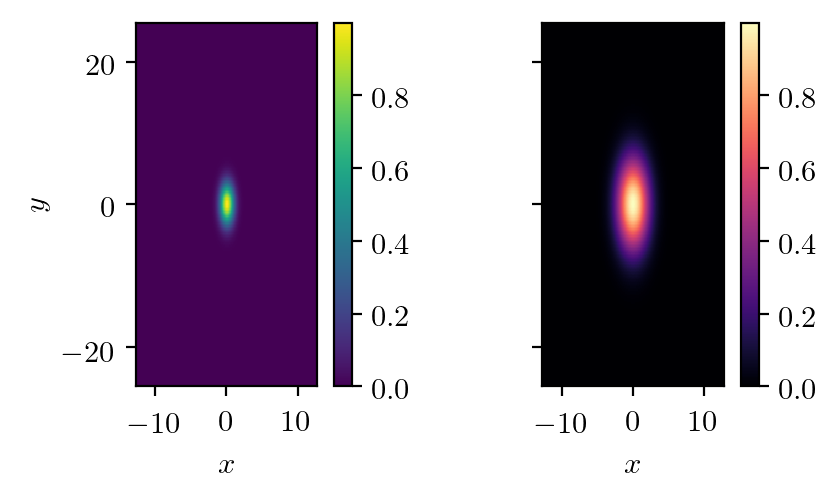

In [16]:
f,axis = plotReImF(f_cpu)

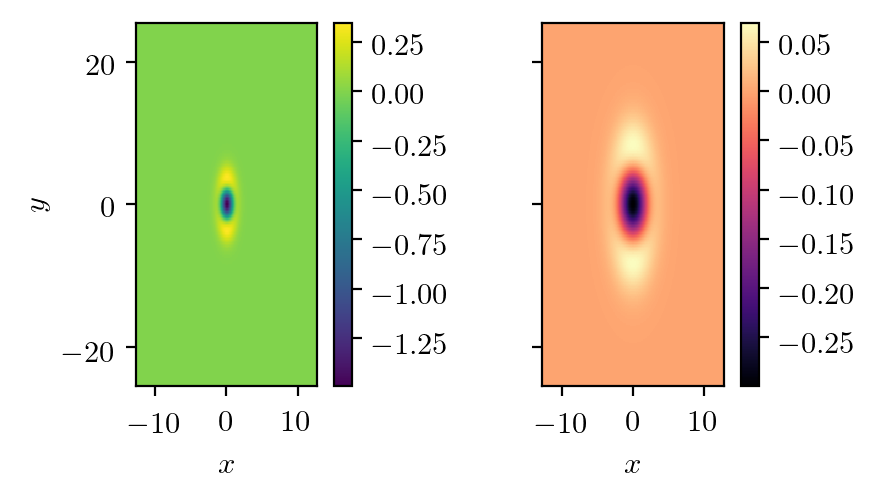

In [17]:
f,axis = plotReImF(Lf_cpu)

In [18]:
func_gpu = gpuarray.zeros(f_cpu.shape, dtype=precc)

In [19]:
func_gpu.nbytes

1048576

In [20]:
precf

numpy.float32

In [21]:
a,b,d,e,

(0.5, 0.25, 0.1, 0.05)

In [22]:
dr,xMin,yMin#precf(a),precf(b),precf(c),precf(d),precf(e),precf(f)

(array([0.1, 0.1], dtype=float32), -12.75, -25.550001)

In [23]:
gaussgpu(dr[0],dr[1],xMin,yMin,
         precf(a),precf(b),
        precf(d),precf(e),int32(0),func_gpu,block=block2D,grid=grid2D)

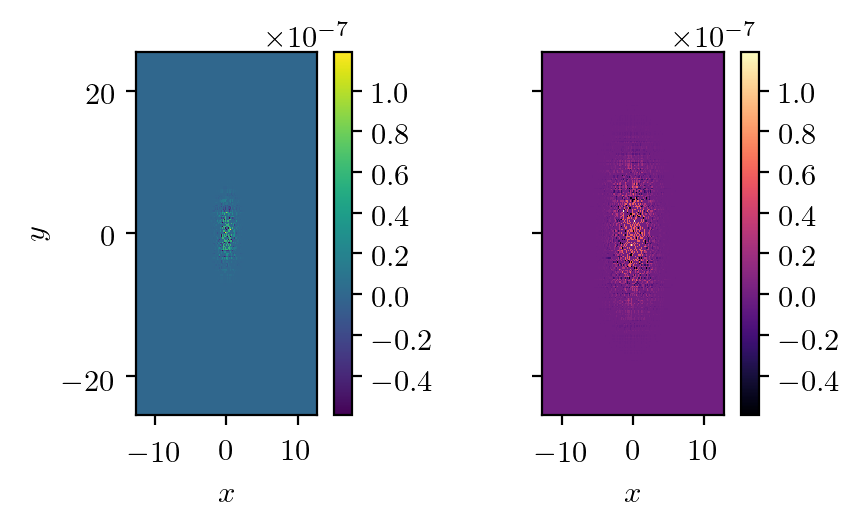

In [24]:
f,axis = plotReImF(f_cpu-func_gpu.get())

# Textures

In [25]:
aux_gpu = gpuarray.zeros_like(func_gpu)

farray_gpu = cuda.gpuarray_to_array(func_gpu, order='C',allowSurfaceBind=True)

tex.set_array(farray_gpu)

ttex(aux_gpu,block=block2D,grid=grid2D)

In [26]:
ctx.synchronize()

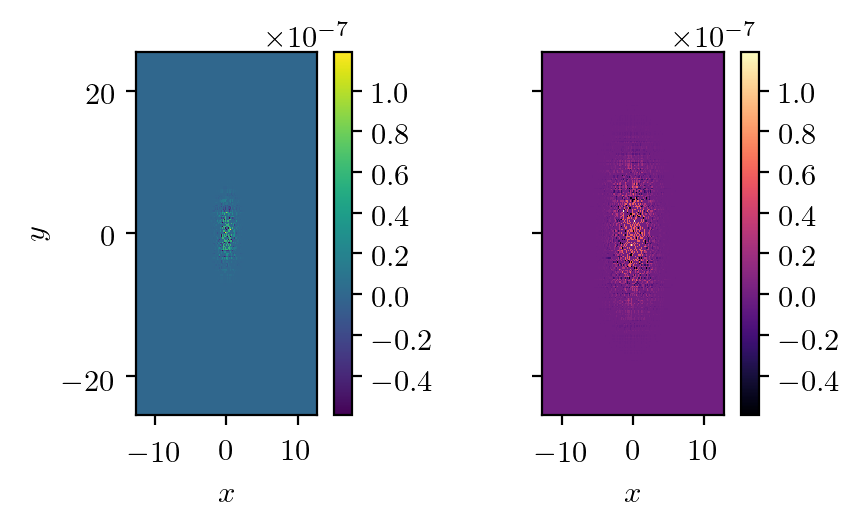

In [27]:
f,axis = plotReImF(f_cpu-aux_gpu.get())

In [28]:
laplaTEX(dr[0],dr[1],aux_gpu,block=block2D,grid=grid2D)

In [29]:
ctx.synchronize()

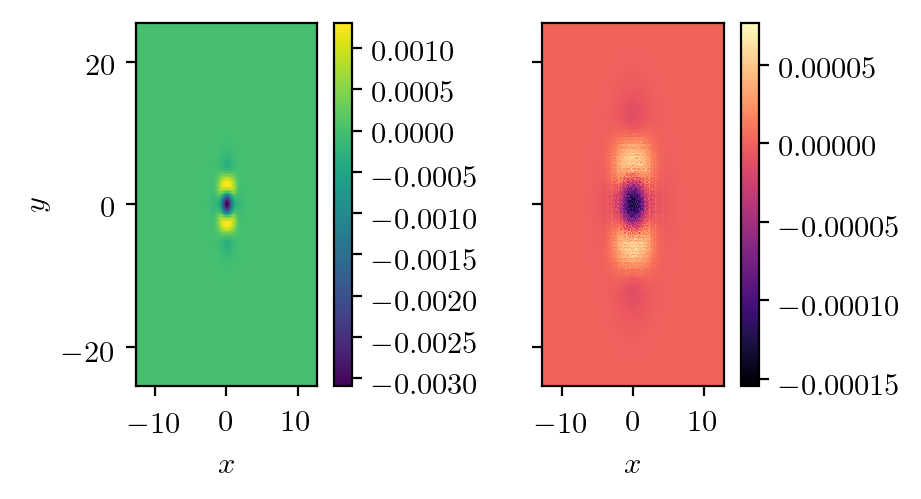

In [30]:
f,axis = plotReImF(Lf_cpu-aux_gpu.get())

# Surfaces

In [31]:
surf.set_array(farray_gpu)
w2surf(func_gpu,block=block2D,grid=grid2D)
tsurf(aux_gpu,block=block2D,grid=grid2D)

In [32]:
ctx.synchronize()

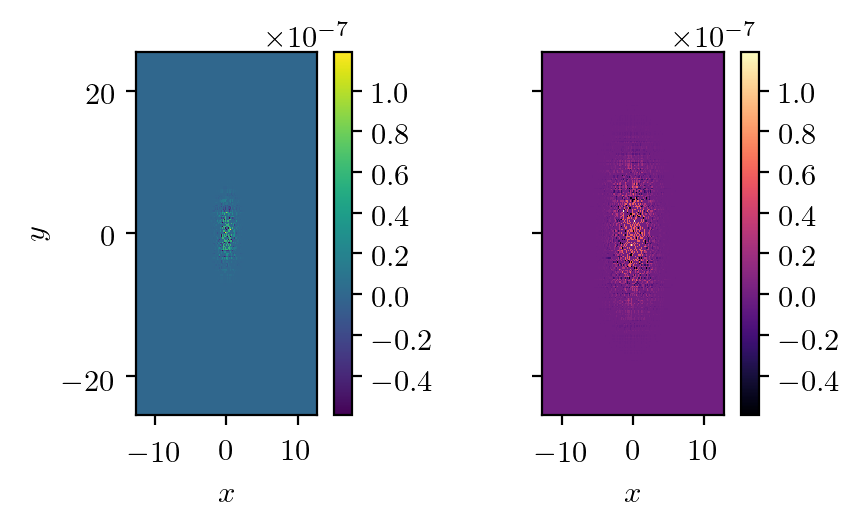

In [33]:
f,axis = plotReImF(f_cpu-aux_gpu.get())

In [34]:
laplaSURF(dr[0],dr[1],aux_gpu,block=block2D,grid=grid2D)

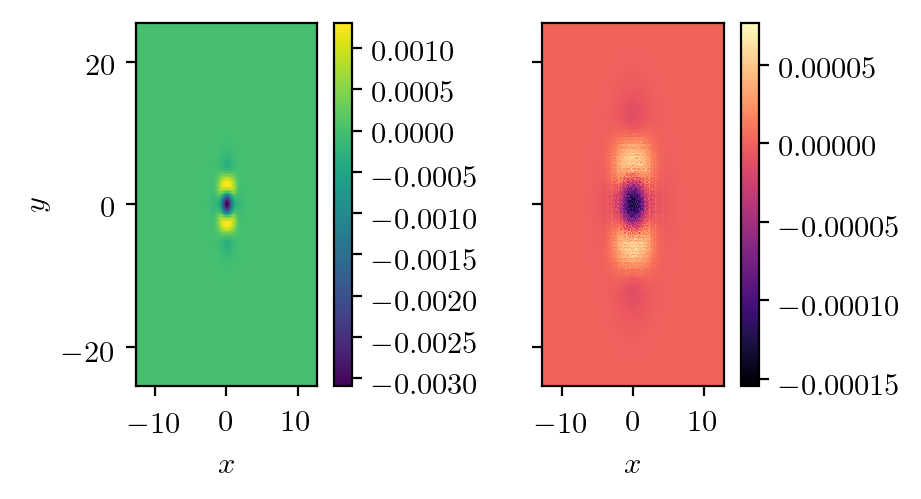

In [35]:
f,axis = plotReImF(Lf_cpu-aux_gpu.get())

In [36]:
setZero(aux_gpu,block=block2D,grid=grid2D)

###  2D Surf

In [37]:
surfNL.set_array(farray_gpu)
w2surfNL(func_gpu,block=block2D,grid=grid2D)
tsurfNL(aux_gpu,block=block2D,grid=grid2D)

In [38]:
ctx.synchronize()

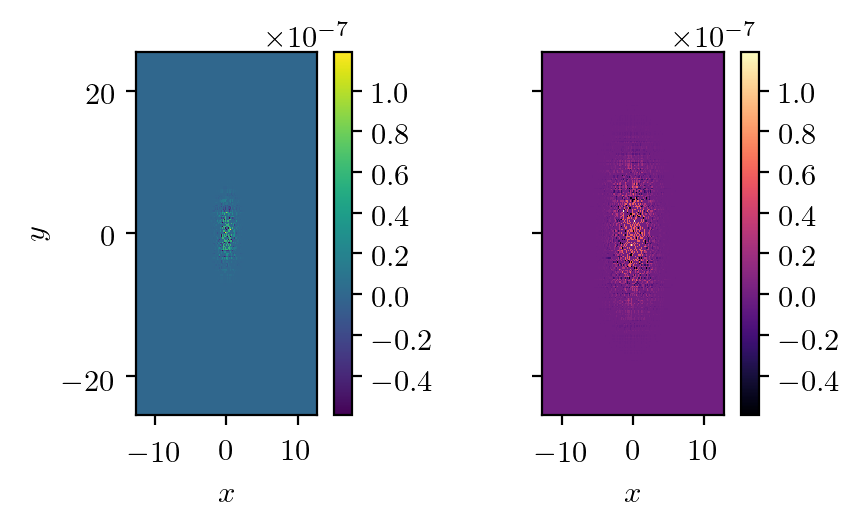

In [39]:
f,axis = plotReImF(f_cpu-aux_gpu.get())

In [40]:
laplaSURFNL(dr[0],dr[1],aux_gpu,block=block2D,grid=grid2D)

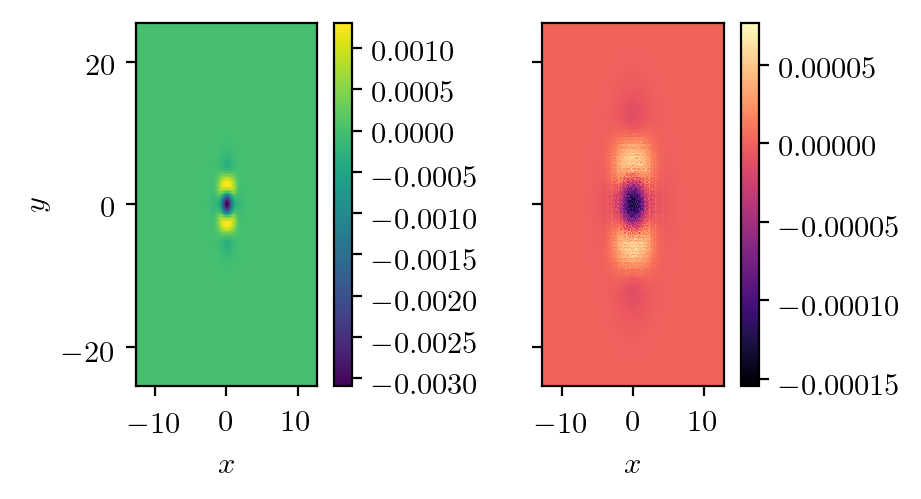

In [41]:
f,axis = plotReImF(Lf_cpu-aux_gpu.get())

# PyFFT

In [42]:
myplan0 = plan1((nPoints[0],nPoints[1]),
                dtype=precc, context=ctx)
aux2_gpu = gpuarray.zeros_like(func_gpu)

In [43]:
myplan0.execute(func_gpu,aux_gpu)
myplan0.execute(aux_gpu,aux2_gpu,inverse=True)

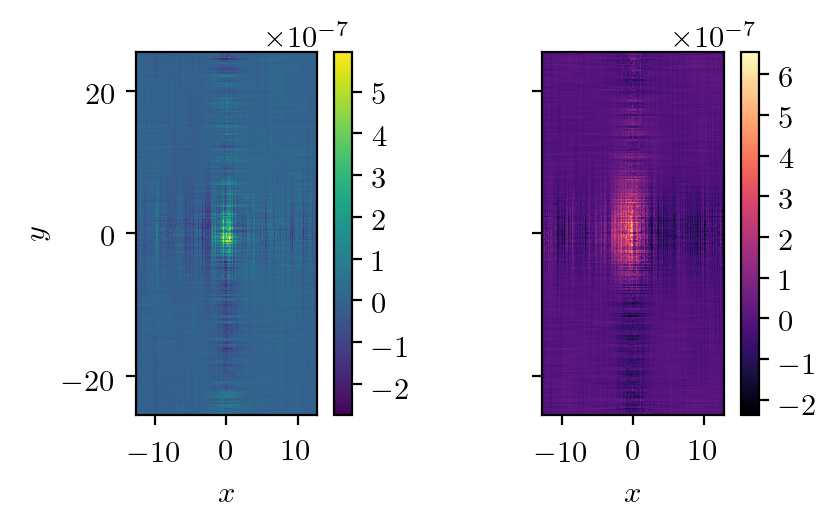

In [44]:
f,axis = plotReImF(f_cpu-aux2_gpu.get())

In [45]:
myplan0.execute(func_gpu,aux_gpu)
laplaFFT(sideX,sideY,nPoints[0],nPoints[1],
        aux_gpu,block=block2D,grid=grid2D)

ctx.synchronize()

In [46]:
myplan0.execute(aux_gpu,aux2_gpu,inverse=True)

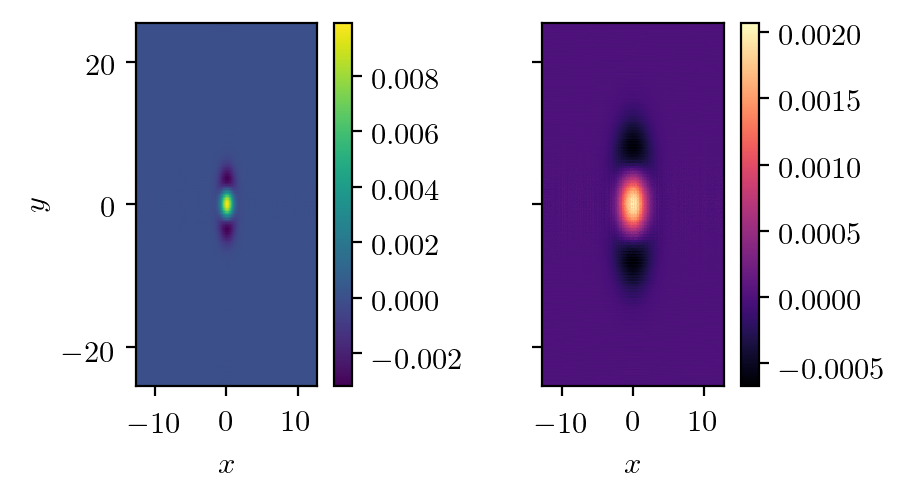

In [47]:
f,axis = plotReImF(Lf_cpu-aux2_gpu.get())

In [48]:
setZero(aux_gpu,block=block2D,grid=grid2D)
setZero(aux2_gpu,block=block2D,grid=grid2D)

# Scikits

In [49]:
myplan1 = plan2(aux_gpu.shape,aux_gpu.dtype,aux_gpu.dtype)

skfft(func_gpu, aux_gpu,myplan1)

laplaFFT(sideX,sideY,nPoints[0],nPoints[1],
        aux_gpu,block=block2D,grid=grid2D)

iskfft(aux_gpu, aux2_gpu,myplan1)

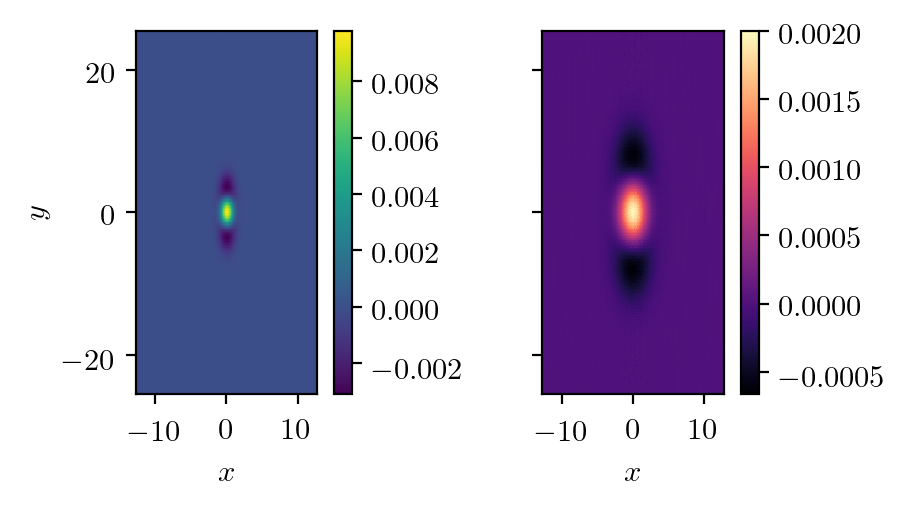

In [50]:
f,axis = plotReImF(Lf_cpu-aux2_gpu.get()/aux2_gpu.size)

In [51]:
setZero(aux_gpu,block=block2D,grid=grid2D)
setZero(aux2_gpu,block=block2D,grid=grid2D)

# Reikna

In [52]:
api = cuda_api()
thr = api.Thread(ctx)

In [53]:
fftPlan3 = FFT(func_gpu)
reikFFT = fftPlan3.compile(thr)

In [54]:
reikFFT(aux_gpu, func_gpu ) # REVERSED CALL Arguments

[None, None, None]

In [55]:
laplaFFT(sideX,sideY,nPoints[0],nPoints[1],
        aux_gpu,block=block2D,grid=grid2D)

In [56]:
reikFFT(aux2_gpu,aux_gpu,inverse=1)

[None, None, None]

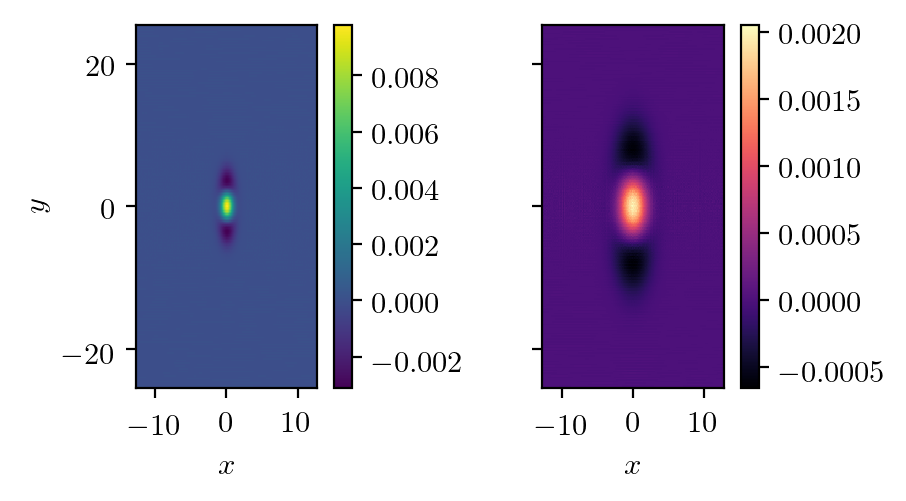

In [57]:
f,axis = plotReImF(Lf_cpu-aux2_gpu.get())

# # # # # # # # # # # 3D # # # # # # # # # # # # # # # 

In [58]:
! nvidia-smi

Wed Feb 13 13:15:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.54                 Driver Version: 396.54                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 780     Off  | 00000000:01:00.0 N/A |                  N/A |
| 30%   53C    P0    N/A /  N/A |    510MiB /  3014MiB |     N/A      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [59]:
prec = 4 # bytes
npPrec = [float32,float64]
npCPrec = [complex64,complex128]
N3D = [2**i for i in range(5,10)]
sizeN3D = [2**(3*i)*prec/(2.0**30) for i in range(5,11)]

N2D = [2**i for i in range(10,16)]
sizeN2D = [2**(2*i)*prec/(2.0**30) for i in range(10,16)]

N1D = [2**i for i in range(20,31)]
sizeN1D = [2**(i)*prec/(2.0**30) for i in range(20,31)]

print '## 1D \n','N=',N1D ,'\n', sizeN1D,'GB'
print '## 2D \n','N=',N2D ,'\n', sizeN2D,'GB'
print '## 3D  \n','N=',N3D ,'\n', sizeN3D,'GB'

## 1D 
N= [1048576, 2097152, 4194304, 8388608, 16777216, 33554432, 67108864, 134217728, 268435456, 536870912, 1073741824] 
[0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0] GB
## 2D 
N= [1024, 2048, 4096, 8192, 16384, 32768] 
[0.00390625, 0.015625, 0.0625, 0.25, 1.0, 4.0] GB
## 3D  
N= [32, 64, 128, 256, 512] 
[0.0001220703125, 0.0009765625, 0.0078125, 0.0625, 0.5, 4.0] GB


In [60]:
auxKernels=''' 
#include <pycuda-complex.hpp>
#include <pycuda-helpers.hpp>

#define pi 3.14159265
#define phi 1.6180339

typedef  pycuda::complex<cudaPres> pyComplex;
surface< void, cudaSurfaceType3D> surf_psi ;
texture< fp_pres, cudaTextureType3D, cudaReadModeElementType> tex_psi ;

__device__ cudaPres KspaceFFT(int tid, int nPoint, cudaPres L){
cudaPres Kfft;
if (tid < nPoint/2){
    Kfft = 2.0f*pi*(tid)/L;
}
else {
    Kfft = 2.0f*pi*(tid-nPoint)/L;
}
return Kfft;
}

__global__ void gaussian_kernel( cudaPres dx,cudaPres dy, cudaPres dz,
                cudaPres xMin,cudaPres yMin, cudaPres zMin,
                cudaPres a,cudaPres b, cudaPres c,
                cudaPres d,cudaPres e, cudaPres f, int caso,
                pyComplex *psi){
int t_i = blockIdx.x*blockDim.x + threadIdx.x;
int t_j = blockIdx.y*blockDim.y + threadIdx.y;
int t_k = blockIdx.z*blockDim.z + threadIdx.z;
int tid   = gridDim.z * blockDim.z * gridDim.y * blockDim.y * t_i + gridDim.z * blockDim.z * t_j + t_k;
cudaPres x=xMin+t_i*dx;
cudaPres y=yMin+t_j*dy;
cudaPres z=zMin+t_k*dz;
pyComplex value;

if (caso==0){
value._M_re=exp(-a*x*x-b*y*y-c*z*z);
value._M_im=exp(-d*x*x-e*y*y-f*z*z);
}
if (caso==1){
value._M_re=x;
value._M_im=y;
}
psi[tid] = value;
}


__global__ void laplaFFT_kernel( cudaPres Lx,cudaPres Ly, cudaPres Lz,
int nPointX,int nPointY, int nPointZ,
pyComplex *fftTrnf){
int t_i = blockIdx.x*blockDim.x + threadIdx.x;
int t_j = blockIdx.y*blockDim.y + threadIdx.y;
int t_k = blockIdx.z*blockDim.z + threadIdx.z;
int tid   = gridDim.z * blockDim.z * gridDim.y * blockDim.y * t_i + gridDim.z * blockDim.z * t_j + t_k;

cudaPres kX = KspaceFFT(t_i,nPointX, Lx);//kx[t_j];
cudaPres kY = KspaceFFT(t_j,nPointY, Ly);//ky[t_i];
cudaPres kZ = KspaceFFT(t_k,nPointZ, Lz);//kz[t_k];
cudaPres k2 = kX*kX + kY*kY + kZ*kZ;
pyComplex value = fftTrnf[tid];
fftTrnf[tid] = -k2*value;
}

__global__ void laplaFDtex_kernel(cudaPres dx, cudaPres dy, cudaPres dz, pyComplex *func_d){
int t_x = blockIdx.x*blockDim.x + threadIdx.x;
int t_y = blockIdx.y*blockDim.y + threadIdx.y;
int t_z = blockIdx.z*blockDim.z + threadIdx.z;
int tid = gridDim.z * blockDim.z * gridDim.y * blockDim.y * t_x + blockDim.z * gridDim.z * t_y + t_z;

pyComplex center, right, left, up, down, top, bottom;

center = fp_tex3D(tex_psi, t_z,   t_y,   t_x);
up =     fp_tex3D(tex_psi, t_z,   t_y+1, t_x);
down =   fp_tex3D(tex_psi, t_z,   t_y-1, t_x);
right =  fp_tex3D(tex_psi, t_z, t_y,   t_x+1);
left =   fp_tex3D(tex_psi, t_z, t_y,   t_x-1);
top =    fp_tex3D(tex_psi, t_z+1,   t_y,   t_x);
bottom = fp_tex3D(tex_psi, t_z-1,   t_y,   t_x);

cudaPres  drInv = 1.0/dy;
pyComplex laplacian = (up + down - 2.0cString*center )*drInv*drInv;
drInv = 1.0/dx;
laplacian += (right + left - 2.0cString*center )*drInv*drInv;
drInv = 1.0/dz;
laplacian += (top + bottom - 2.0cString*center )*drInv*drInv;
func_d[tid] = laplacian;
}

__global__ void laplaFDsurf_kernel(cudaPres dx, cudaPres dy, cudaPres dz, pyComplex *func_d){
int t_x = blockIdx.x*blockDim.x + threadIdx.x;
int t_y = blockIdx.y*blockDim.y + threadIdx.y;
int t_z = blockIdx.z*blockDim.z + threadIdx.z;
int tid = gridDim.z * blockDim.z * gridDim.y * blockDim.y * t_x + blockDim.z * gridDim.z * t_y + t_z;

pyComplex center, right, left, up, down, top, bottom;

fp_surf3Dread(&center,surf_psi, t_z,   t_y,   t_x, cudaBoundaryModeZero);
fp_surf3Dread(&up,surf_psi, t_z,   t_y+1, t_x, cudaBoundaryModeZero);
fp_surf3Dread(&down,surf_psi, t_z,   t_y-1, t_x, cudaBoundaryModeZero);
fp_surf3Dread(&right,surf_psi, t_z, t_y,   t_x+1, cudaBoundaryModeZero);
fp_surf3Dread(&left,surf_psi, t_z, t_y,   t_x-1, cudaBoundaryModeZero);
fp_surf3Dread(&top,surf_psi, t_z+1,   t_y,   t_x, cudaBoundaryModeZero);
fp_surf3Dread(&bottom,surf_psi, t_z-1,   t_y,   t_x, cudaBoundaryModeZero);

cudaPres drInv = 1.0/dy;
pyComplex laplacian = (up + down - 2.0cString*center )*drInv*drInv;
drInv = 1.0/dx;
laplacian += (right + left - 2.0cString*center )*drInv*drInv;
drInv = 1.0/dz;
laplacian += (top + bottom - 2.0cString*center )*drInv*drInv;
func_d[tid] = laplacian;
}

__global__ void test_tex_kernel( pyComplex *func_d){
int t_x = blockIdx.x*blockDim.x + threadIdx.x;
int t_y = blockIdx.y*blockDim.y + threadIdx.y;
int t_z = blockIdx.z*blockDim.z + threadIdx.z;
int tid = gridDim.z * blockDim.z * gridDim.y * blockDim.y * t_x + blockDim.z * gridDim.z * t_y + t_z;

pyComplex center;

center = fp_tex3D(tex_psi, t_z,   t_y,   t_x);

func_d[tid] = center;
}

__global__ void test_surf_kernel(pyComplex *func_d){
int t_x = blockIdx.x*blockDim.x + threadIdx.x;
int t_y = blockIdx.y*blockDim.y + threadIdx.y;
int t_z = blockIdx.z*blockDim.z + threadIdx.z;
int tid = gridDim.z * blockDim.z * gridDim.y * blockDim.y * t_x + blockDim.z * gridDim.z * t_y + t_z;

pyComplex center;

fp_surf3Dread(&center,surf_psi, t_z,   t_y,   t_x, cudaBoundaryModeZero);

func_d[tid] = center;
}

__global__ void setzero_kernel(pyComplex *func_d){

int t_x = blockIdx.x*blockDim.x + threadIdx.x;
int t_y = blockIdx.y*blockDim.y + threadIdx.y;
int t_z = blockIdx.z*blockDim.z + threadIdx.z;
int tid = gridDim.z * blockDim.z * gridDim.y * blockDim.y * t_x + blockDim.z * gridDim.z * t_y + t_z;
func_d[tid] *=0;
}

__global__ void write2surf_kernel(pyComplex *realArray1){

// This kernel writes quantum pressure and non linear term of energy

int t_x = blockIdx.x*blockDim.x + threadIdx.x;
int t_y = blockIdx.y*blockDim.y + threadIdx.y;
int t_z = blockIdx.z*blockDim.z + threadIdx.z;
int tid = gridDim.z * blockDim.z * gridDim.y * blockDim.y * t_x + blockDim.z * gridDim.z * t_y + t_z;

pyComplex arr1 = realArray1[tid];
// cudaPres arr2 = realArray2[tid];

// Write to Surfaces

fp_surf3Dwrite(  arr1, surf_psi,   t_z, t_y, t_x,  cudaBoundaryModeClamp);
// fp_surf3Dwrite(  arr2, surf_psi0OutImag,  t_x*sizeof(cudaPres), t_y, t_z,  cudaBoundaryModeClamp);
}
'''

We test against an complex gaussian function (real and imaginary):
### $$f(x,y,z) = e^{-a\, x^2\,-b\, y^2\,-c\, z^2} + i e^{-d\, x^2 -e\, y^2 -f\, z^2}$$
then the laplacian is 

$$\nabla^2 f(x,y,z) = (4a^2x^2+4b^2y^2+4c^2z^2-2(a+b+c))e^{-a\, x^2\,-b\, y^2\,-c\, z^2} + i (4d^2x^2+4e^2y^2+4f^2z^2-2(d+e+f)) e^{-d\, x^2 -e\, y^2 -f\, z^2}$$

In [61]:
prec='single'
if prec=='single':
    precf = float32
    precc = complex64
    kernelprec = 'float'
    divisionTol = precf(1e-9)
    cString = 'f'
    fpName = 'fp_tex_cfloat'
elif prec=='double':
    precf = float64
    precc = complex128
    kernelprec = 'double'
    divisionTol = 0.0
    cString = ''
    fpName = 'fp_tex_cdouble'

auxKernels = auxKernels.replace('cudaPres', kernelprec)
auxKernels = auxKernels.replace('cString', cString)
auxKernels = auxKernels.replace('fp_pres', fpName)
compiledK = SourceModule(auxKernels)

In [62]:
print auxKernels

 
#include <pycuda-complex.hpp>
#include <pycuda-helpers.hpp>

#define pi 3.14159265
#define phi 1.6180339

typedef  pycuda::complex<float> pyComplex;
surface< void, cudaSurfaceType3D> surf_psi ;
texture< fp_tex_cfloat, cudaTextureType3D, cudaReadModeElementType> tex_psi ;

__device__ float KspaceFFT(int tid, int nPoint, float L){
float Kfft;
if (tid < nPoint/2){
    Kfft = 2.0f*pi*(tid)/L;
}
else {
    Kfft = 2.0f*pi*(tid-nPoint)/L;
}
return Kfft;
}

__global__ void gaussian_kernel( float dx,float dy, float dz,
                float xMin,float yMin, float zMin,
                float a,float b, float c,
                float d,float e, float f, int caso,
                pyComplex *psi){
int t_i = blockIdx.x*blockDim.x + threadIdx.x;
int t_j = blockIdx.y*blockDim.y + threadIdx.y;
int t_k = blockIdx.z*blockDim.z + threadIdx.z;
int tid   = gridDim.z * blockDim.z * gridDim.y * blockDim.y * t_i + gridDim.z * blockDim.z * t_j + t_k;
float x=xMin+t_i*dx;
float y=yMin+t_j*dy;
float z=zMin+t_k*

In [63]:
laplaTEX =compiledK.get_function('laplaFDtex_kernel')
laplaSURF=compiledK.get_function('laplaFDsurf_kernel')
laplaFFT =compiledK.get_function('laplaFFT_kernel')
tex = compiledK.get_texref('tex_psi')
surf= compiledK.get_surfref('surf_psi')

ttex =compiledK.get_function('test_tex_kernel')
tsurf =compiledK.get_function('test_surf_kernel')
setZero =compiledK.get_function('setzero_kernel')
w2surf = compiledK.get_function('write2surf_kernel')
gaussgpu = compiledK.get_function('gaussian_kernel')

In [64]:
dr = array([0.1,0.25,0.3],dtype=precf)
nPoints = array([512,256,128],dtype=int32)

a,b,c = 0.5,0.25,0.1
d,e,f = 2.,1.,0.75

sideX = precf(dr[0]*(nPoints[0]-1))
sideY = precf(dr[1]*(nPoints[1]-1))
sideZ = precf(dr[2]*(nPoints[2]-1))

xMax,xMin = sideX/precf(2.), -sideX/precf(2.)
yMax,yMin = sideY/precf(2.), -sideY/precf(2.)
zMax,zMin = sideZ/precf(2.), -sideZ/precf(2.)

xPoints = array([xMin+dr[0]*i for i in range(nPoints[0])],dtype=precf)#linspace(xMin,xMax,nPoints[0]).astype(precf)
yPoints = array([yMin+dr[1]*i for i in range(nPoints[1])],dtype=precf)#linspace(yMin,yMax,nPoints[1]).astype(precf)
zPoints = array([zMin+dr[2]*i for i in range(nPoints[2])],dtype=precf)#linspace(zMin,zMax,nPoints[2]).astype(precf)

X, Y, Z = meshgrid(xPoints,yPoints,zPoints,indexing='ij')

In [65]:
params = [a,b,c,d,e,f]

In [66]:
g,h,i = params[0:3]
params[3:6]

[2.0, 1.0, 0.75]

In [67]:
params
getFreeMemory(show=False)

2503.3125

xPoints.shape,xPoints

In [68]:
xPoints

array([-25.550001  , -25.45      , -25.35      , -25.250002  ,
       -25.150002  , -25.050001  , -24.95      , -24.85      ,
       -24.750002  , -24.650002  , -24.550001  , -24.45      ,
       -24.35      , -24.250002  , -24.150002  , -24.050001  ,
       -23.95      , -23.85      , -23.750002  , -23.650002  ,
       -23.550001  , -23.45      , -23.35      , -23.250002  ,
       -23.150002  , -23.050001  , -22.95      , -22.85      ,
       -22.750002  , -22.650002  , -22.550001  , -22.45      ,
       -22.35      , -22.250002  , -22.150002  , -22.050001  ,
       -21.95      , -21.85      , -21.750002  , -21.650002  ,
       -21.550001  , -21.45      , -21.35      , -21.250002  ,
       -21.150002  , -21.050001  , -20.95      , -20.85      ,
       -20.750002  , -20.650002  , -20.550001  , -20.45      ,
       -20.35      , -20.250002  , -20.150002  , -20.050001  ,
       -19.95      , -19.85      , -19.750002  , -19.650002  ,
       -19.550001  , -19.45      , -19.35      , -19.25

In [69]:
sideX,sideY,sideZ

(51.100002, 63.75, 38.100002)

In [70]:
X.dtype,sideX.dtype,xMin.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

In [71]:
block_size_x, block_size_y, block_size_z = 8,8,8
gridx = int32(nPoints[0] // block_size_x + 1 * ( nPoints[0] % block_size_x != 0 ))
gridy = int32(nPoints[1] // block_size_y + 1 * ( nPoints[1] % block_size_y != 0 ))
gridz = int32(nPoints[2] // block_size_z + 1 * ( nPoints[2] % block_size_z != 0 ))
grid3D = (int(gridx), int(gridy), int(gridz))
block3D = (int(block_size_x), int(block_size_y), int(block_size_z))

In [72]:
array(grid3D)*array(block3D), nPoints

(array([512, 256, 128]), array([512, 256, 128], dtype=int32))

In [73]:
cutZ = int(nPoints[2]/2)-1
cutX = int(nPoints[0]/2)-1
cutY = int(nPoints[1]/2)-1

pcoordZ = float(zMin+cutZ*dr[2])
pcoordY = float(yMin+cutY*dr[1])
pcoordX = float(xMin+cutX*dr[0])

indicesX = (slice(0,None),cutY,cutZ) 
indicesY = (cutX,slice(0,None),cutZ) 
indicesZ = (cutX,cutY,slice(0,None))

In [74]:
f_cpu = exp(-a*X*X-b*Y*Y-c*Z*Z)+1j*exp(-d*X*X-e*Y*Y-f*Z*Z)
f_cpu.dtype

dtype('complex64')

In [75]:
f_cpu.nbytes/(1024.*1024.)

128.0

In [76]:
f_cpu.dtype

dtype('complex64')

In [77]:
f_cpu.size*1.0*2*4/(1024*1024)

128.0

In [78]:
Lf_cpu = (4*a*a*X*X+4*b*b*Y*Y+4*c*c*Z*Z-2*(a+b+c))*exp(-a*X*X-b*Y*Y-c*Z*Z)+\
(4*d*d*X*X+4*e*e*Y*Y+4*f*f*Z*Z-2*(d+e+f))*1j*exp(-d*X*X-e*Y*Y-f*Z*Z)
Lf_cpu.dtype

dtype('complex64')

In [79]:
def plot1Dcut(arraysClx):
    scale = 120
    # Image size
    nsubX = 2
    nsubY = 3

    width,height = 4*scale*(nsubX+1*(nsubX==0)),3*scale*(nsubY+1*(nsubY==0))

    # Pixel border around image
    border = 1

    dpi = 200.0
    figsize= (width+2*border)/float(dpi), (height+2*border)/float(dpi)
    fig,ax = subplots((nsubY+1*(nsubY==0)),(nsubX+1*(nsubX==0)),
                  figsize=figsize, dpi=dpi, facecolor="white", sharey=True)

    hpixel = 1.0/(width+2*border)
    vpixel = 1.0/(height+2*border)

    fig.subplots_adjust(left=border*hpixel, bottom=border*vpixel,
                    right=1-2*border*hpixel, top=1-2*border*vpixel)#,
                    #wspace=0, hspace=0)
    counter = 0
    lwi=0.75
    alp = 0.25
    marksi=2
    markersl = ['.-','v-','o-','*-']
    for arr in arraysClx:
        ax[0,0].plot(xPoints,arr[indicesX].real,markersl[counter],lw=lwi,ms=marksi,alpha=alp)
        ax[0,1].plot(xPoints,arr[indicesX].imag,markersl[counter],lw=lwi,ms=marksi,alpha=alp)
        
        ax[1,0].plot(yPoints,arr[indicesY].real,markersl[counter],lw=lwi,ms=marksi,alpha=alp)
        ax[1,1].plot(yPoints,arr[indicesY].imag,markersl[counter],lw=lwi,ms=marksi,alpha=alp)
        
        ax[2,0].plot(zPoints,arr[indicesZ].real,markersl[counter],lw=lwi,ms=marksi,alpha=alp)
        ax[2,1].plot(zPoints,arr[indicesZ].imag,markersl[counter],lw=lwi,ms=marksi,alpha=alp)
        counter+=1
    return fig

f = plot1Dcut([f_cpu,Lf_cpu])

plot(f_cpu[indicesX].real)
plot(f_cpu[indicesY].real)
plot(f_cpu[indicesZ].real)
plot(f_cpu[indicesX].imag)
plot(f_cpu[indicesY].imag)
plot(f_cpu[indicesZ].imag)

plot(Lf_cpu[indicesX].real)
plot(Lf_cpu[indicesY].real)
plot(Lf_cpu[indicesZ].real)
plot(Lf_cpu[indicesX].imag)
plot(Lf_cpu[indicesY].imag)
plot(Lf_cpu[indicesZ].imag)

## Textures

In [80]:
func_gpu = gpuarray.zeros(f_cpu.shape,dtype=precc)

In [81]:
func_gpu.gpudata

In [82]:
func_gpu.nbytes

134217728

In [83]:
precf

numpy.float32

In [84]:
a,b,c,d,e,f

(0.5, 0.25, 0.1, 2.0, 1.0, 0.75)

In [85]:
dr,xMin,yMin,zMin,#precf(a),precf(b),precf(c),precf(d),precf(e),precf(f)

(array([0.1 , 0.25, 0.3 ], dtype=float32), -25.550001, -31.875, -19.050001)

In [86]:
gaussgpu(dr[0],dr[1],dr[2],xMin,yMin,zMin,
         precf(a),precf(b),precf(c),
        precf(d),precf(e),precf(f), int32(1),func_gpu,block=block3D,grid=grid3D)

In [87]:
mesh = func_gpu.get()

In [88]:
mesh.shape

(512, 256, 128)

mesh[:,0,0].real

0.1


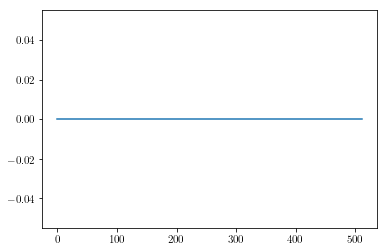

In [89]:
print dr[0]
plot(xPoints - mesh[:,0,0].real)

0.25


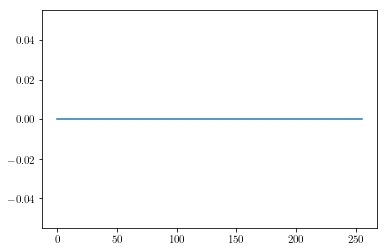

In [90]:
print dr[1]
plot(yPoints - mesh[0,:,0].imag)

In [91]:
gaussgpu(dr[0],dr[1],dr[2],xMin,yMin,zMin,
         precf(a),precf(b),precf(c),
        precf(d),precf(e),precf(f), int32(0),func_gpu,block=block3D,grid=grid3D)

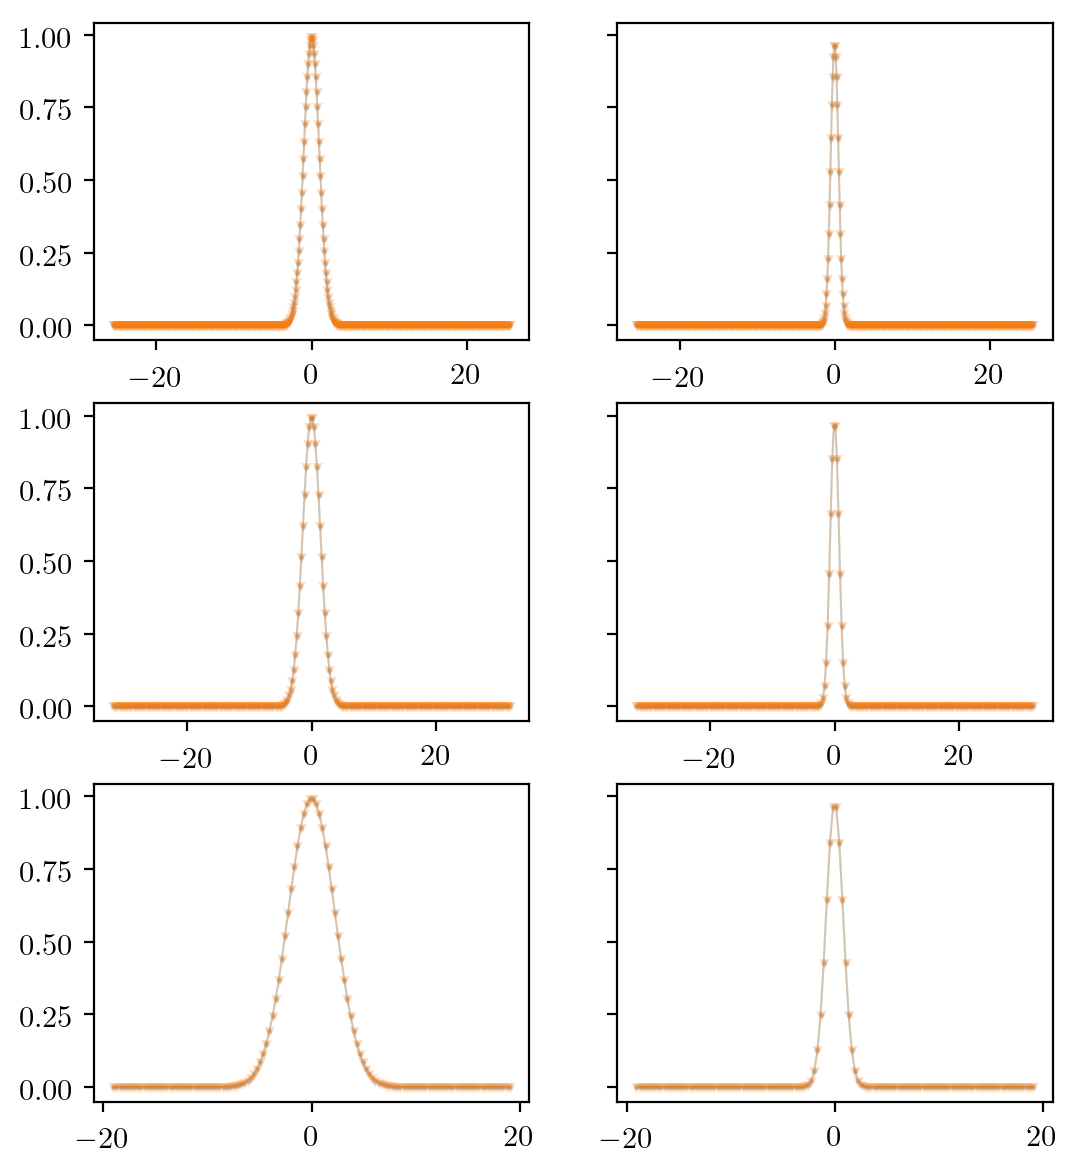

In [92]:
fig = plot1Dcut([f_cpu,func_gpu.get()])

In [93]:
aux_gpu = gpuarray.zeros_like(func_gpu)

In [94]:
farray_gpu = cuda.gpuarray_to_array(func_gpu, order='C',allowSurfaceBind=True)

In [95]:
tex.set_array(farray_gpu)

In [96]:
ttex(aux_gpu,block=block3D,grid=grid3D)

In [97]:
testTEX = aux_gpu.get()

f = plot1Dcut([f_cpu,aux_gpu.get()])

plot(testTEX[indicesX].real)
plot(testTEX[indicesY].real)
plot(testTEX[indicesZ].real)
plot(testTEX[indicesX].imag)
plot(testTEX[indicesY].imag)
plot(testTEX[indicesZ].imag)

In [98]:
#void laplaFDtex_kernel(cudaPres dx, cudaPres dy, cudaPres dz, pyComplex *func_d){
laplaTEX(dr[0],dr[1],dr[2],aux_gpu,block=block3D,grid=grid3D)

In [99]:
ctx.synchronize()

In [100]:
laplaFFT4 = aux_gpu.get()

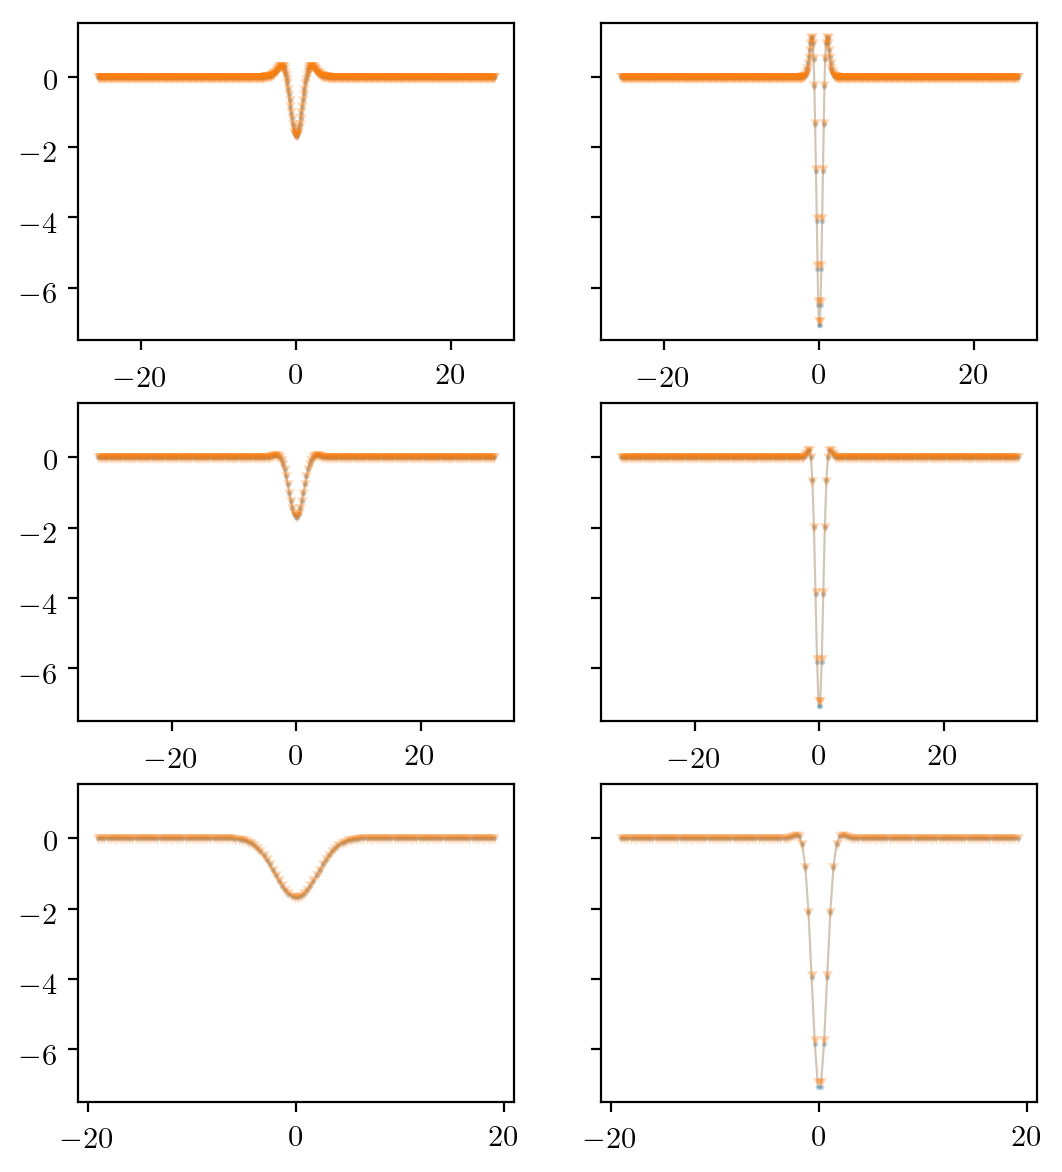

In [101]:
f = plot1Dcut([Lf_cpu,laplaFFT4])

In [102]:
surf.set_array(farray_gpu)
w2surf(aux_gpu,block=block3D,grid=grid3D)

In [103]:
setZero(aux_gpu,block=block3D,grid=grid3D)

In [104]:
tex.set_array(farray_gpu)
ttex(aux_gpu,block=block3D,grid=grid3D)
testTEX = aux_gpu.get()

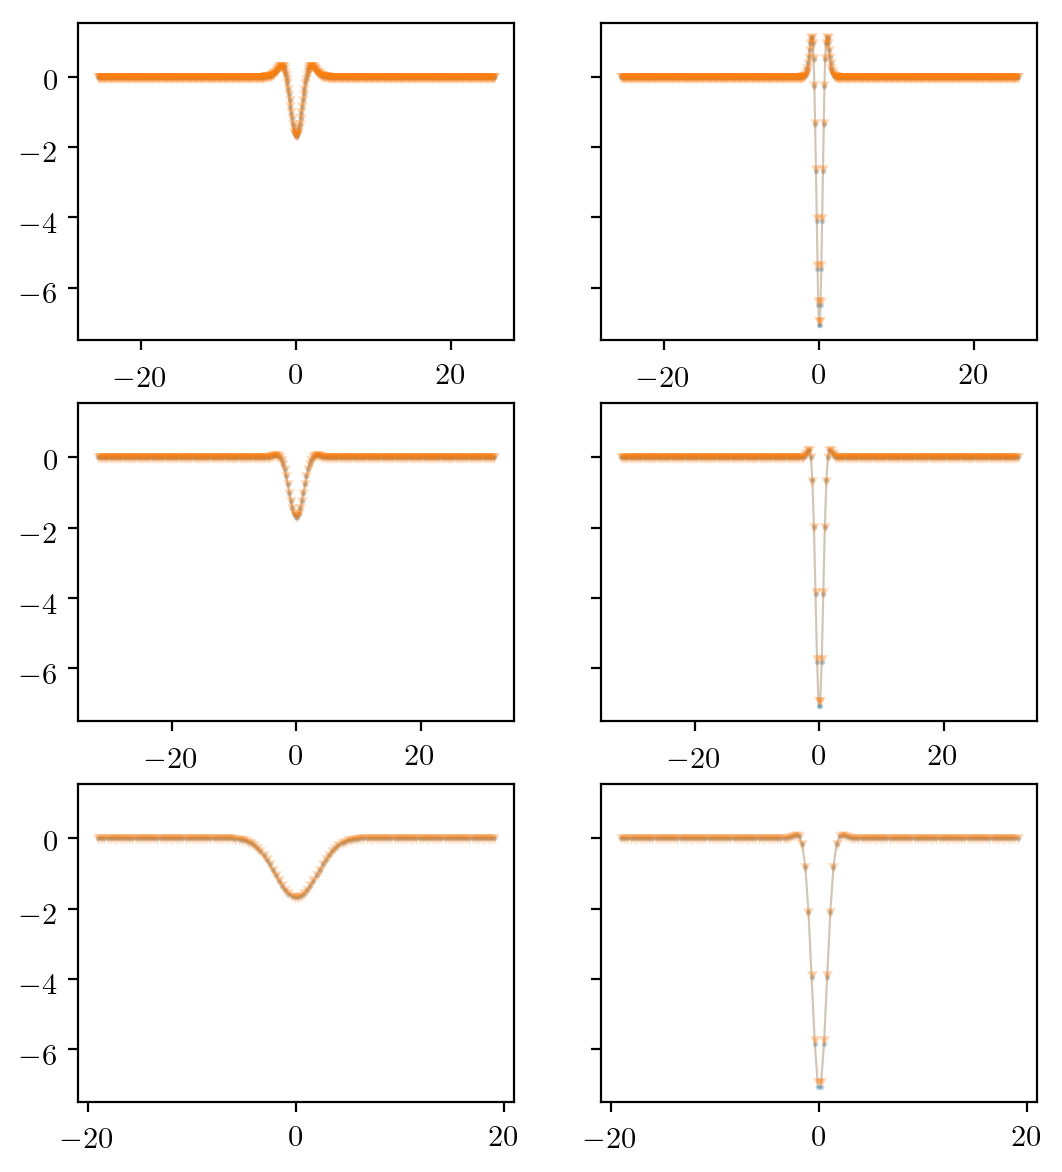

In [105]:
f = plot1Dcut([Lf_cpu,aux_gpu.get()])

plot(laplaFFT4[indicesX].real)
plot(laplaFFT4[indicesY].real)
plot(laplaFFT4[indicesZ].real)
plot(laplaFFT4[indicesX].imag)
plot(laplaFFT4[indicesY].imag)
plot(laplaFFT4[indicesZ].imag)

In [106]:
surf.set_array(farray_gpu)
w2surf(func_gpu,block=block3D,grid=grid3D)

In [107]:
tsurf(aux_gpu,block=block3D,grid=grid3D)

In [108]:
testSURF = aux_gpu.get()

f = plot1Dcut([f_cpu,testSURF])

plot(testSURF[indicesX].real)
plot(testSURF[indicesY].real)
plot(testSURF[indicesZ].real)
plot(testSURF[indicesX].imag)
plot(testSURF[indicesY].imag)
plot(testSURF[indicesZ].imag)

In [109]:
laplaSURF(dr[0],dr[1],dr[2],aux_gpu,block=block3D,grid=grid3D)

In [110]:
laplaFFT5 = aux_gpu.get()

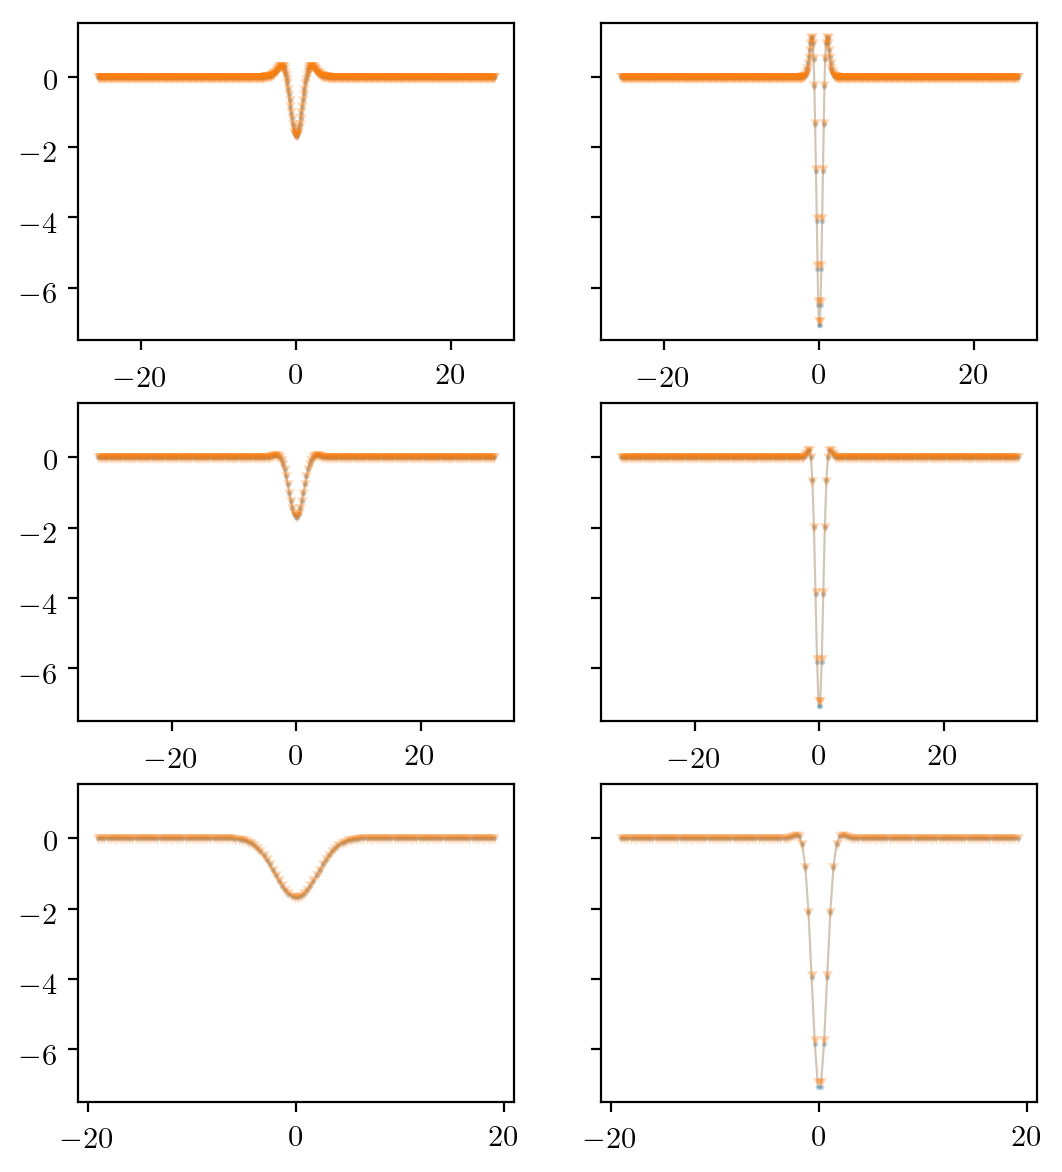

In [111]:
f = plot1Dcut([Lf_cpu,laplaFFT5])

In [112]:
setZero(aux_gpu,block=block3D,grid=grid3D)

plot(laplaFFT5[indicesX].real)
plot(laplaFFT5[indicesY].real)
plot(laplaFFT5[indicesZ].real)
plot(laplaFFT5[indicesX].imag)
plot(laplaFFT5[indicesY].imag)
plot(laplaFFT5[indicesZ].imag)

## PYFFT

In [113]:
myplan0 = plan1((nPoints[0],nPoints[1],nPoints[2]),
                dtype=precc, context=ctx)

In [114]:
aux_gpu.dtype

dtype('complex64')

In [115]:
aux2_gpu = gpuarray.zeros_like(func_gpu)

In [116]:
myplan0.execute(func_gpu,aux_gpu)

f = plot1Dcut([f_cpu,func_gpu.get()])

In [117]:
laplaFFT(sideX,sideY,sideZ,nPoints[0],nPoints[1],nPoints[2],
        aux_gpu,block=block3D,grid=grid3D)

In [118]:
ctx.synchronize()

myplan0.execute(aux_gpu,inverse=True)

In [119]:
myplan0.execute(aux_gpu,aux2_gpu,inverse=True)

In [120]:
laplaFFT1 = aux2_gpu.get()
#f_gpu = func_gpu.get()

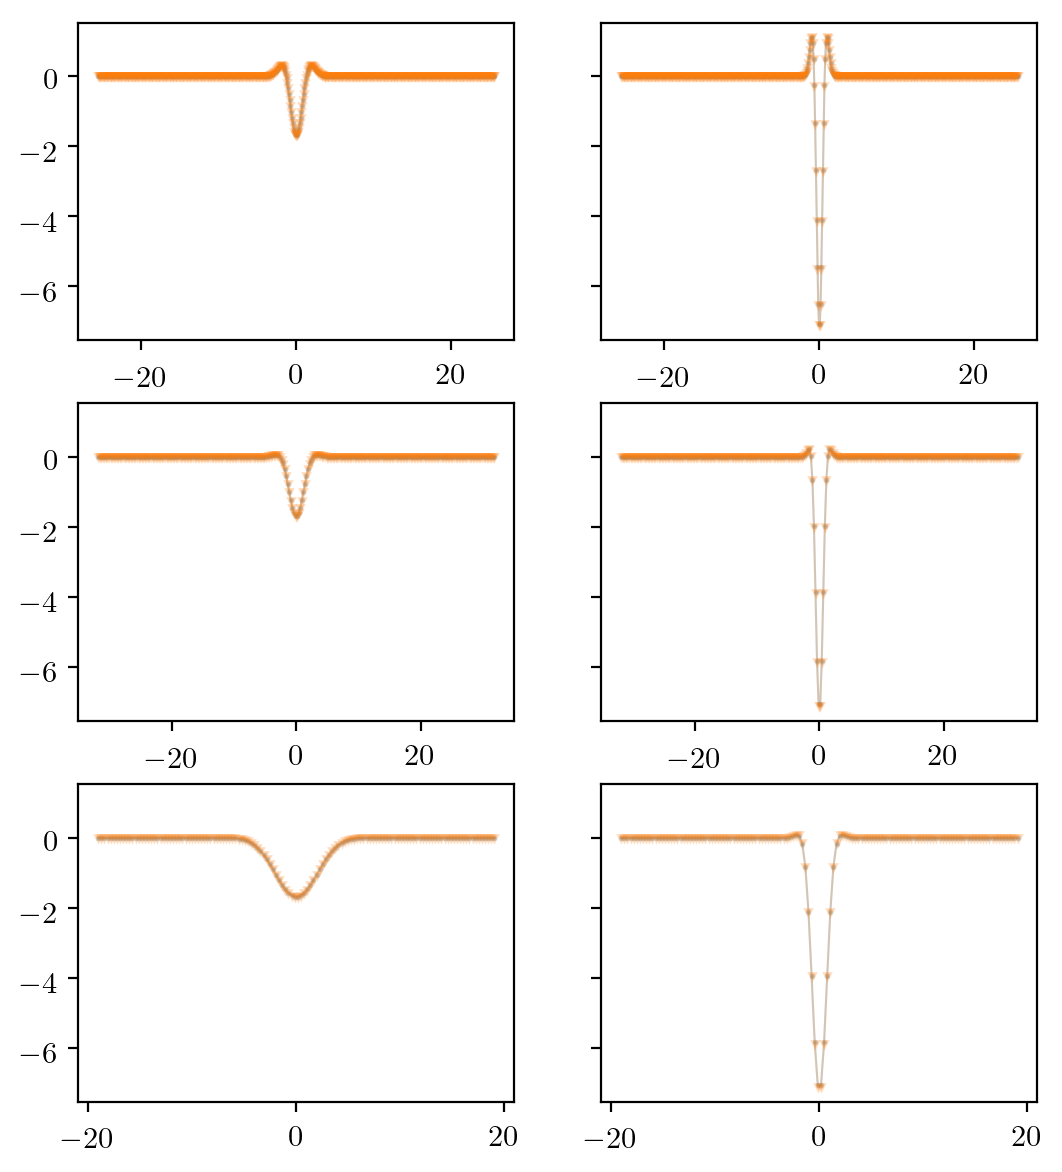

In [121]:
f = plot1Dcut([Lf_cpu,laplaFFT1])

In [122]:
setZero(aux_gpu,block=block3D,grid=grid3D)
setZero(aux2_gpu,block=block3D,grid=grid3D)

f = plot1Dcut([f_cpu,func_gpu.get()])

plot(f_gpu[indicesX].real)
plot(f_gpu[indicesY].real)
plot(f_gpu[indicesZ].real)
plot(f_gpu[indicesX].imag)
plot(f_gpu[indicesY].imag)
plot(f_gpu[indicesZ].imag)

plot(laplaFFT1[indicesX].real)
plot(laplaFFT1[indicesY].real)
plot(laplaFFT1[indicesZ].real)
plot(laplaFFT1[indicesX].imag)
plot(laplaFFT1[indicesY].imag)
plot(laplaFFT1[indicesZ].imag)

## SCIKITS

In [123]:
aux_gpu.shape,cumprod(aux_gpu.shape)[2],aux_gpu.size

((512, 256, 128), 16777216, 16777216)

In [124]:
myplan1 = plan2(aux_gpu.shape,aux_gpu.dtype,aux_gpu.dtype)

In [125]:
skfft(func_gpu, aux_gpu,myplan1)

In [126]:
laplaFFT(sideX,sideY,sideZ,nPoints[0],nPoints[1],nPoints[2],
        aux_gpu,block=block3D,grid=grid3D)

aux2_gpu = gpuarray.zeros_like(func_gpu)

In [127]:
iskfft(aux_gpu, aux2_gpu,myplan1)

In [128]:
laplaFFT2 = aux2_gpu.get()

In [129]:
laplaFFT2.size

16777216

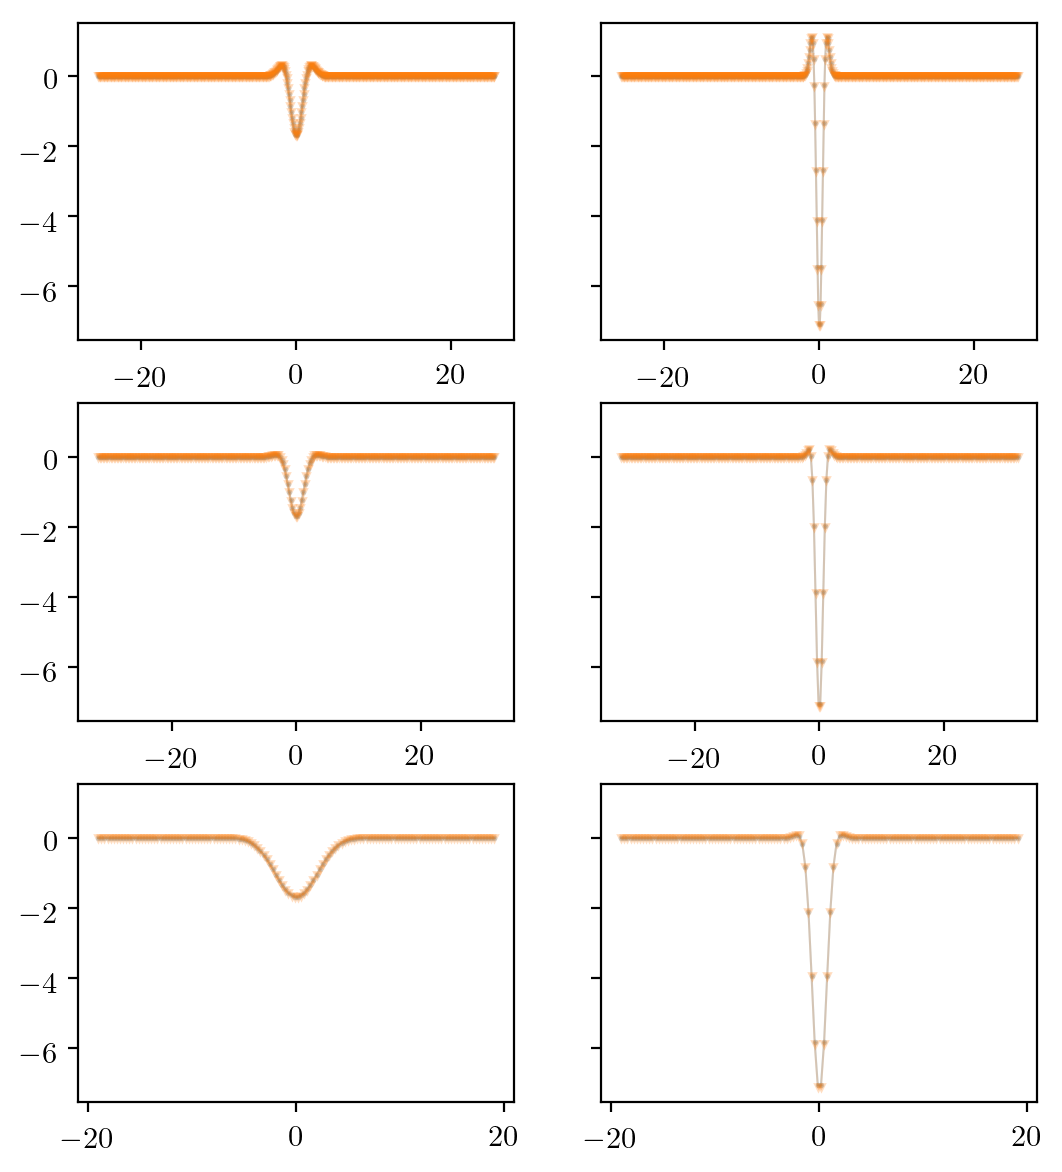

In [130]:
f = plot1Dcut([Lf_cpu,laplaFFT2/laplaFFT2.size])

In [131]:
setZero(aux_gpu,block=block3D,grid=grid3D)
setZero(aux2_gpu,block=block3D,grid=grid3D)

## REIKNA

In [132]:
api = cuda_api()
thr = api.Thread(ctx)

In [133]:
fftPlan3 = FFT(func_gpu)
reikFFT = fftPlan3.compile(thr)

In [134]:
reikFFT(aux_gpu, func_gpu ) # REVERSED CALL Arguments

[None, None, None, None, None]

In [135]:
laplaFFT(sideX,sideY,sideZ,nPoints[0],nPoints[1],nPoints[2],
        aux_gpu,block=block3D,grid=grid3D)

In [136]:
reikFFT(aux2_gpu,aux_gpu,inverse=1)

[None, None, None, None, None]

In [137]:
laplaFFT3 = aux2_gpu.get()

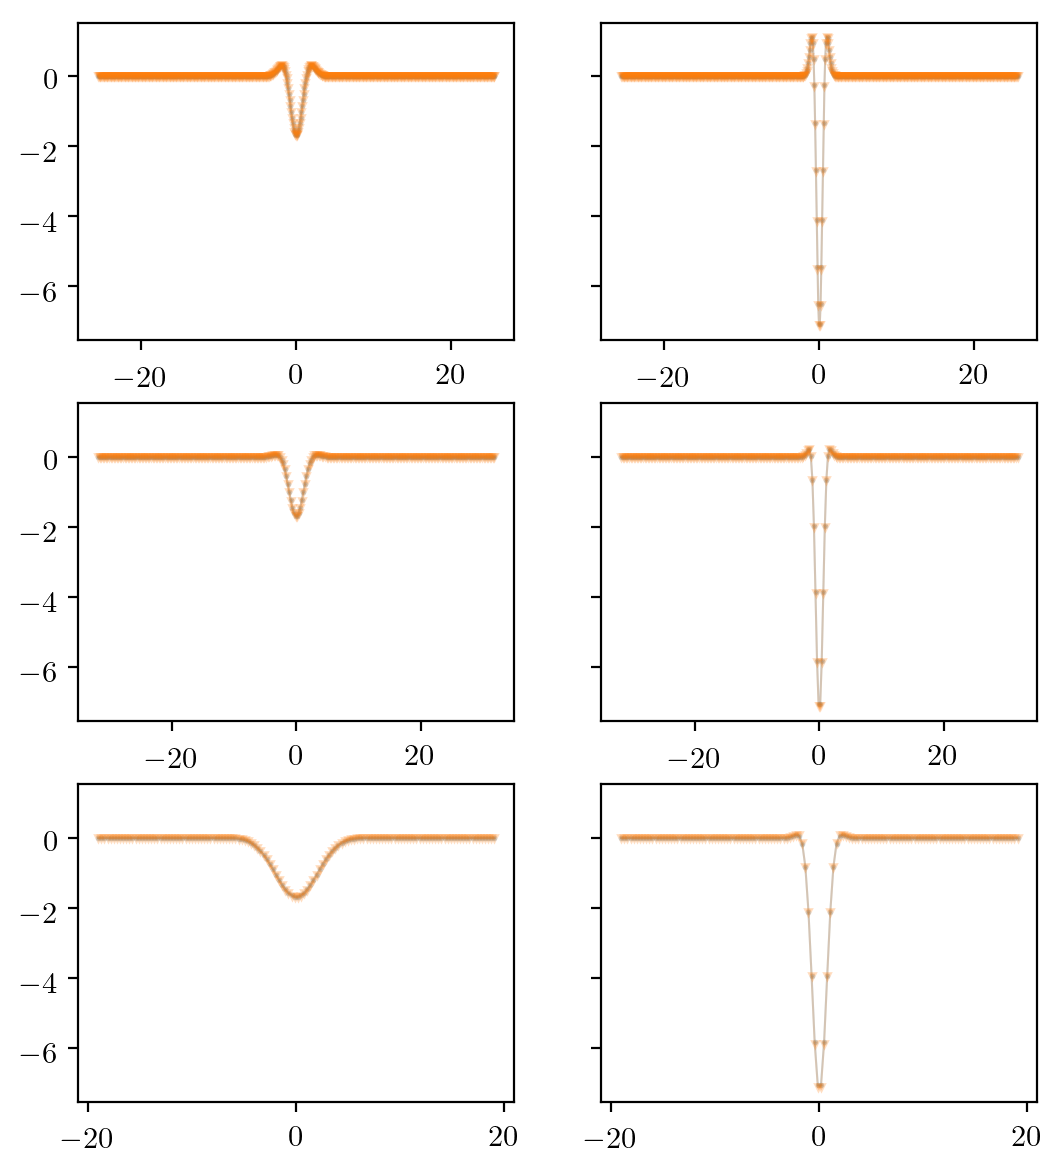

In [138]:
f = plot1Dcut([Lf_cpu,laplaFFT3])

plot(laplaFFT3[indicesX].real/laplaFFT3.size)
plot(laplaFFT3[indicesY].real/laplaFFT3.size)
plot(laplaFFT3[indicesZ].real/laplaFFT3.size)
plot(laplaFFT3[indicesX].imag/laplaFFT3.size)
plot(laplaFFT3[indicesY].imag/laplaFFT3.size)
plot(laplaFFT3[indicesZ].imag/laplaFFT3.size)

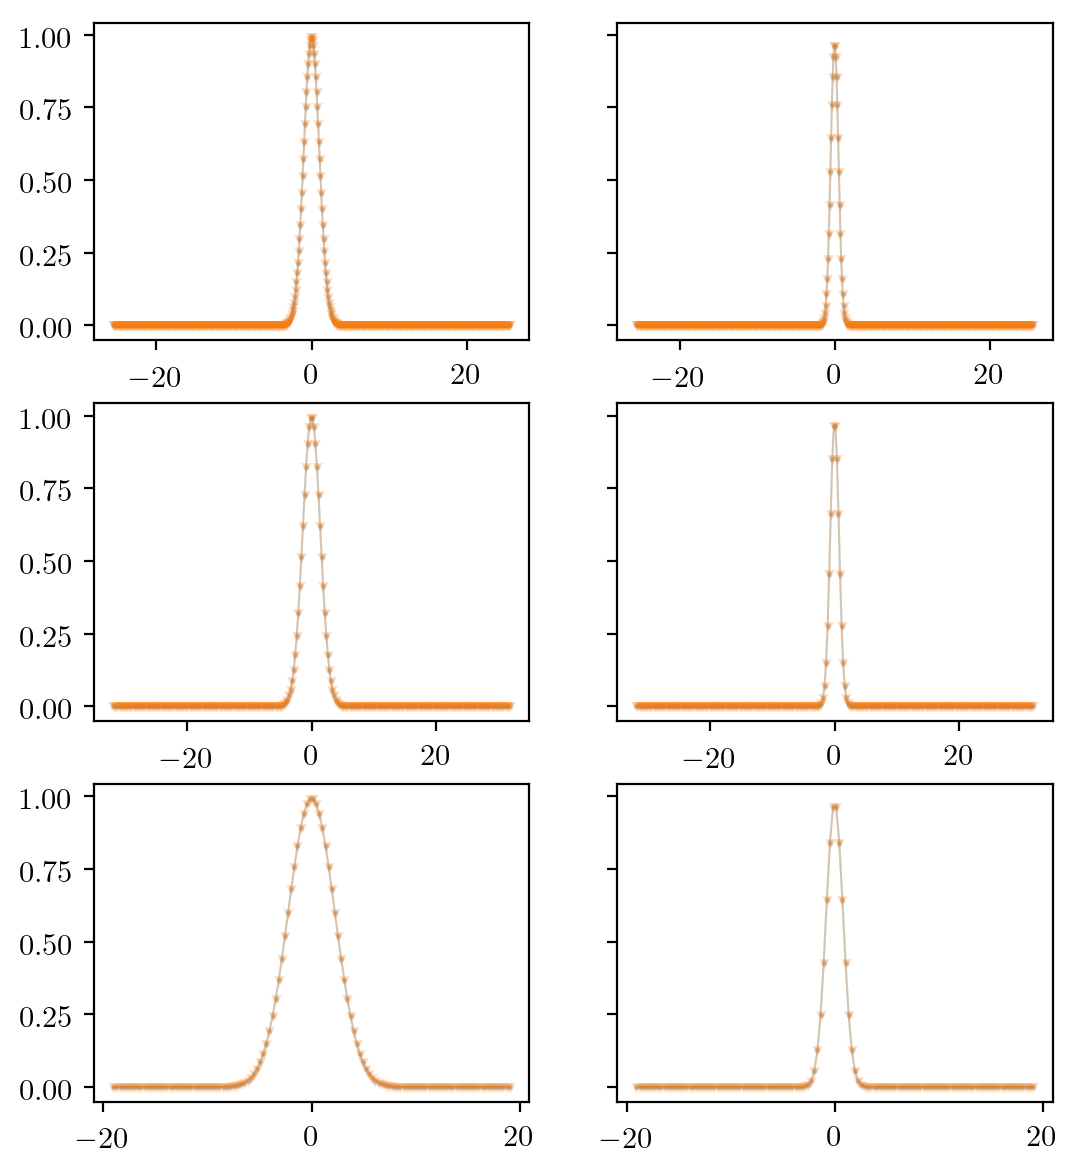

In [139]:
f = plot1Dcut([f_cpu,func_gpu.get()])

In [140]:
print sum(abs(Lf_cpu.real-laplaFFT4.real)), sum(abs(Lf_cpu.imag-laplaFFT4.imag))
print sum(abs(Lf_cpu.real-laplaFFT5.real)), sum(abs(Lf_cpu.imag-laplaFFT5.imag))
print sum(abs(Lf_cpu.real-laplaFFT1.real)), sum(abs(Lf_cpu.imag-laplaFFT1.imag))
print sum(abs(Lf_cpu.real-laplaFFT2.real/laplaFFT2.size)), sum(abs(Lf_cpu.imag-laplaFFT2.imag/laplaFFT2.size))
print sum(abs(Lf_cpu.real-laplaFFT3.real)), sum(abs(Lf_cpu.imag-laplaFFT3.imag))


29.317087 50.52681
29.317087 50.52681
51.28722 26.742302
46.54499571190412 22.19535536759533
50.87364 26.411526


In [141]:
sum(laplaFFT3.real-Lf_cpu.real)

0.000370474

In [142]:
Lf_cpu

array([[[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+